In [16]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import glob

In [17]:
df_bra = pd.read_csv('./brazil/pre_proc_data.csv', sep=',')

In [18]:
df_bra = df_bra[['text', 'created_at', 'text_sentiment', 'sentiment_value']]

In [19]:
df_bra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505184 entries, 0 to 1505183
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   text             1501296 non-null  object 
 1   created_at       1501293 non-null  object 
 2   text_sentiment   1505184 non-null  object 
 3   sentiment_value  1505184 non-null  float64
dtypes: float64(1), object(3)
memory usage: 45.9+ MB


In [20]:
df_pt = pd.concat(map(pd.read_csv, glob.glob('./pt/data/*.csv')))

In [21]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4943520 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   created_at       object 
 2   text_sentiment   object 
 3   sentiment_value  float64
dtypes: float64(1), object(3)
memory usage: 188.6+ MB


In [22]:
df = pd.concat([df_bra,df_pt])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6448704 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   created_at       object 
 2   text_sentiment   object 
 3   sentiment_value  float64
dtypes: float64(1), object(3)
memory usage: 246.0+ MB


In [24]:
df = df.drop_duplicates()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5251649 entries, 0 to 9975
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   created_at       object 
 2   text_sentiment   object 
 3   sentiment_value  float64
dtypes: float64(1), object(3)
memory usage: 200.3+ MB


In [26]:
df['date'] = df['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d') if isinstance(x, str) else 0
)
df['date'] = pd.to_datetime(df['date'])
df = df[df["date"] >= '2019-11-01']

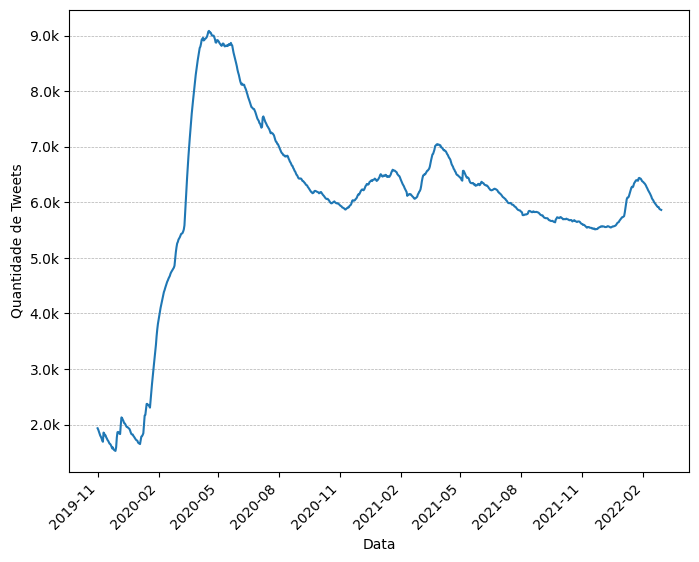

In [27]:
from matplotlib.ticker import FuncFormatter
from typing import List
import matplotlib.dates as mdates

def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))

df_ = df["date"].groupby(df["date"]).count().reset_index(name ='quantity')
df_

plt.xlabel("Data")
plt.ylabel("Quantidade de Tweets")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
half_year_locator = mdates.MonthLocator(interval=3)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45, ha='right')
ax.plot(df_['date'], smooth(df_['quantity'], 0.95))

In [28]:
df['sentiment'] = df.apply(lambda x: 'Negativo' if x['sentiment_value'] <= -.05 else 'Positivo' if x['sentiment_value'] >= .05 else 'Neutro', axis=1)

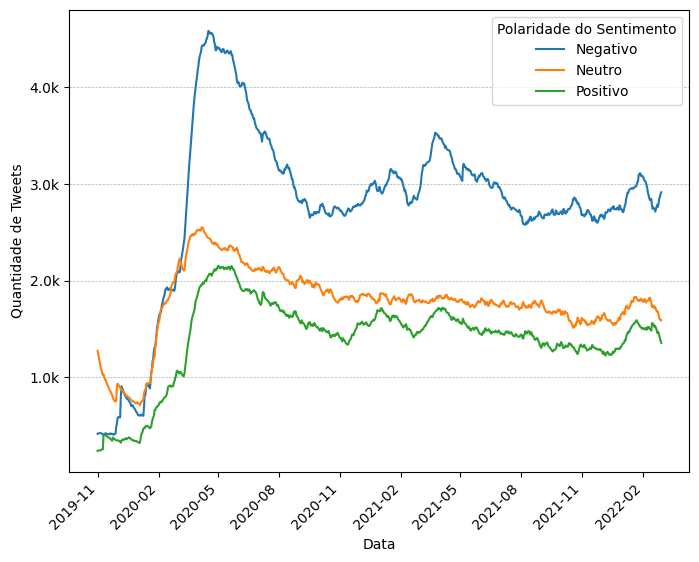

In [29]:
from matplotlib.ticker import FuncFormatter
from typing import List

def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))

df_ = df[["date", "sentiment"]].groupby(["date", "sentiment"]).size().reset_index(name ='quantity').pivot(index='date', columns='sentiment', values='quantity').reset_index()
df_

plt.xlabel("Data")
plt.ylabel("Quantidade de Tweets")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
half_year_locator = mdates.MonthLocator(interval=3)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45, ha='right')

num=0
for column in df_.drop('date', axis=1):
    num+=1
    plt.plot(df_['date'], smooth(df_[column], 0.95), marker='', label=column)
ax.legend(title="Polaridade do Sentimento")

(array([  31015.,  100194.,  140692.,  169177.,  173532.,  213818.,
         186054.,  227239.,  260033.,  162388.,  323464.,  111042.,
         196454.,   91256.,   75480., 1500630.,  111023.,   74026.,
          95473.,  146981.,  135506.,  174412.,  108346.,   85158.,
          90017.,   64408.,   52274.,   30330.,   16065.,    3387.]),
 array([-9.98700000e-01, -9.32126667e-01, -8.65553333e-01, -7.98980000e-01,
        -7.32406667e-01, -6.65833333e-01, -5.99260000e-01, -5.32686667e-01,
        -4.66113333e-01, -3.99540000e-01, -3.32966667e-01, -2.66393333e-01,
        -1.99820000e-01, -1.33246667e-01, -6.66733333e-02, -1.00000000e-04,
         6.64733333e-02,  1.33046667e-01,  1.99620000e-01,  2.66193333e-01,
         3.32766667e-01,  3.99340000e-01,  4.65913333e-01,  5.32486667e-01,
         5.99060000e-01,  6.65633333e-01,  7.32206667e-01,  7.98780000e-01,
         8.65353333e-01,  9.31926667e-01,  9.98500000e-01]),
 <BarContainer object of 30 artists>)

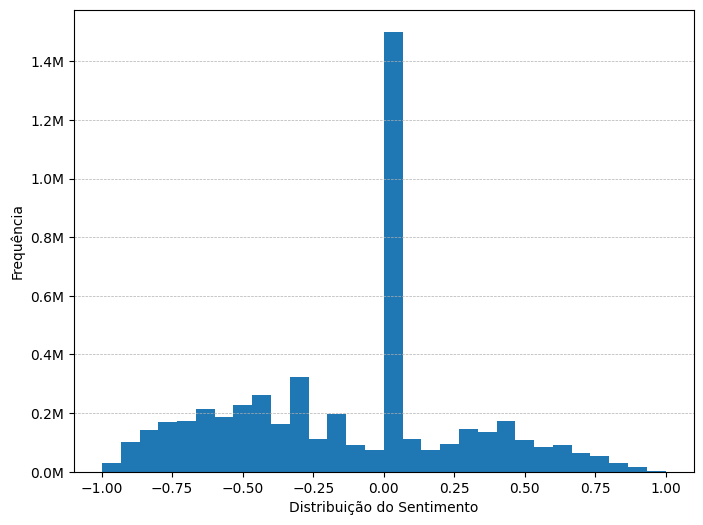

In [30]:
from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df['sentiment_value'], bins=30)

(array([  7961.,  37753.,  61665.,  77441.,  87081.,  91282., 105522.,
        118981.,  89613., 151129.,  85796., 162037., 111136., 133992.,
        180365., 106345.,  62664., 285466.,  68009.,  74410.,  35201.,
        192913.,  33766.,  55175.,      0.,      0.,  82565.,  31599.,
         60006.,  40732.,  62548.,  94448.,  82435.,  50975.,  87554.,
         87125., 115749.,  57646.,  63221.,  44175.,  64462.,  39167.,
         43070.,  32216.,  27784.,  19510.,  15509.,   9610.,   4416.,
           737.]),
 array([-9.98700e-01, -9.58756e-01, -9.18812e-01, -8.78868e-01,
        -8.38924e-01, -7.98980e-01, -7.59036e-01, -7.19092e-01,
        -6.79148e-01, -6.39204e-01, -5.99260e-01, -5.59316e-01,
        -5.19372e-01, -4.79428e-01, -4.39484e-01, -3.99540e-01,
        -3.59596e-01, -3.19652e-01, -2.79708e-01, -2.39764e-01,
        -1.99820e-01, -1.59876e-01, -1.19932e-01, -7.99880e-02,
        -4.00440e-02, -1.00000e-04,  3.98440e-02,  7.97880e-02,
         1.19732e-01,  1.59676e-01, 

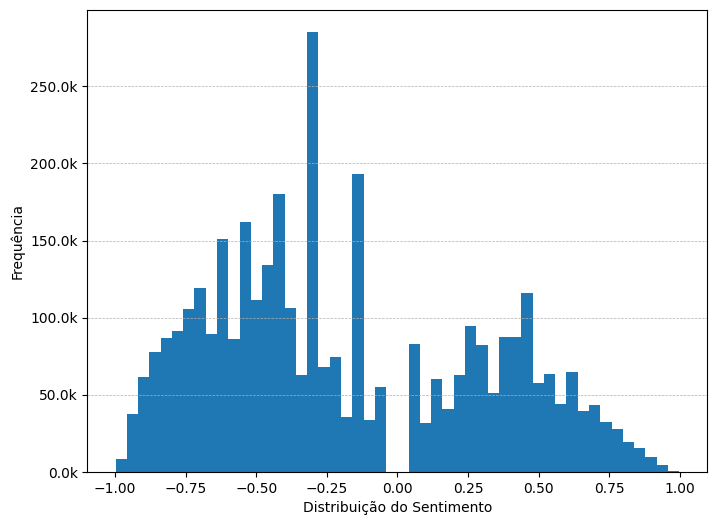

In [31]:
df_ = df[df['sentiment'] != 'Neutro']

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=50)

In [32]:
df_.count()

text               3632962
created_at         3632962
text_sentiment     3632962
sentiment_value    3632962
date               3632962
sentiment          3632962
dtype: int64

(array([ 66500., 181408., 237468., 263079., 323771., 259023., 332593.,
        360396., 269006., 122459.]),
 array([-0.9987 , -0.90383, -0.80896, -0.71409, -0.61922, -0.52435,
        -0.42948, -0.33461, -0.23974, -0.14487, -0.05   ]),
 <BarContainer object of 10 artists>)

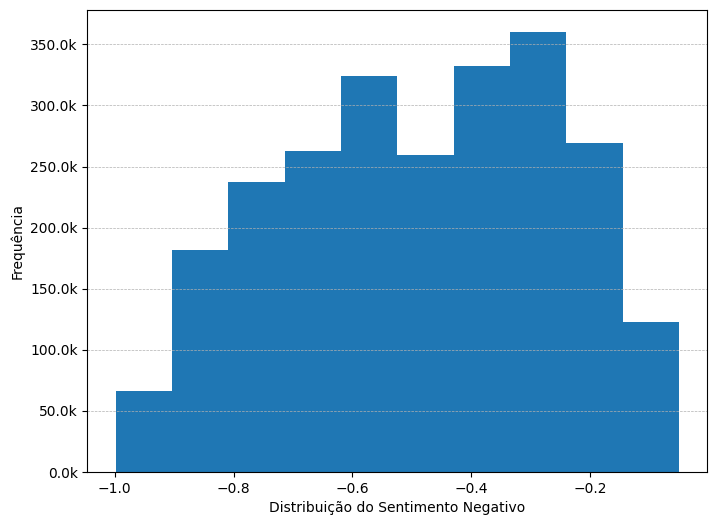

In [33]:
df_ = df[(df['sentiment'] == 'Negativo')]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento Negativo")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=10)

(array([146572., 130883., 180461., 216931., 180774., 132702., 113532.,
         71466.,  35565.,   8373.]),
 array([0.0504 , 0.14521, 0.24002, 0.33483, 0.42964, 0.52445, 0.61926,
        0.71407, 0.80888, 0.90369, 0.9985 ]),
 <BarContainer object of 10 artists>)

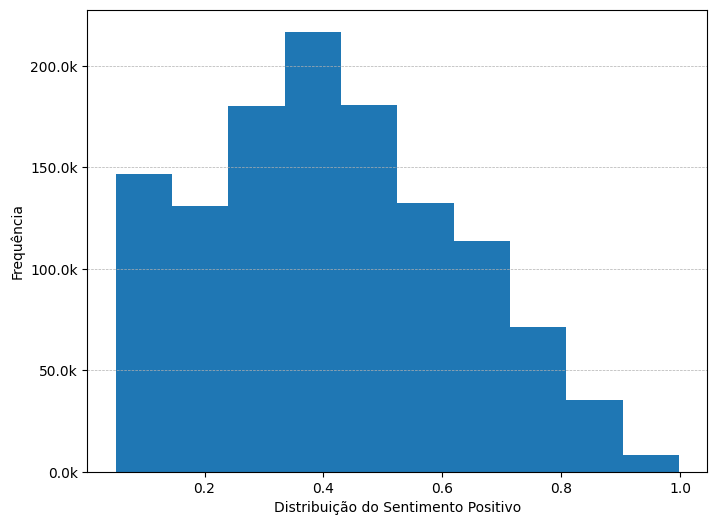

In [34]:
df_ = df[(df['sentiment'] == 'Positivo')]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento Positivo")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=10)

(array([6.64000e+02, 1.96800e+03, 4.10840e+04, 1.50200e+03, 9.22000e+02,
        1.43662e+06, 1.16600e+03, 2.80650e+04, 4.05400e+03, 8.67000e+02]),
 array([-0.0498 , -0.03984, -0.02988, -0.01992, -0.00996,  0.     ,
         0.00996,  0.01992,  0.02988,  0.03984,  0.0498 ]),
 <BarContainer object of 10 artists>)

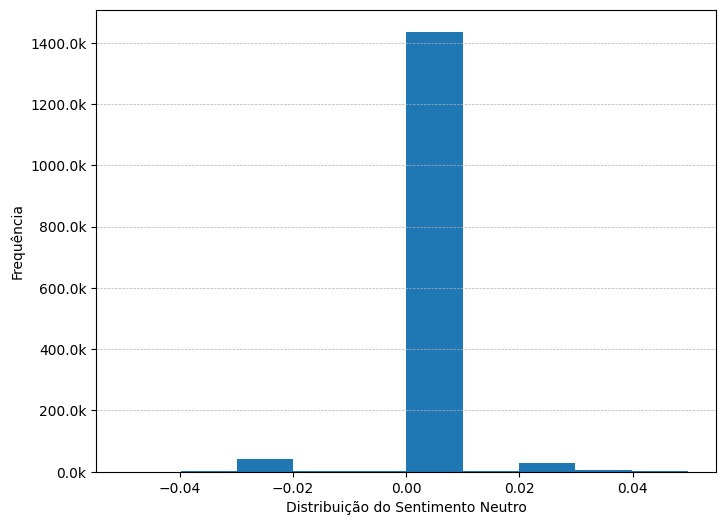

In [37]:
df_ = df[(df['sentiment'] == 'Neutro')]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento Neutro")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=10)

In [36]:
# df.to_csv('pre_proc_data_pt_brazil.csv', sep=',')